In [2]:
import boto3
import sagemaker 
from sagemaker import clarify

import os
from IPython.display import Image

role = sagemaker.get_execution_role()
sess = sagemaker.session.Session()

input_image_path = "s3://sagemaker-project-p-o3c1kiruwcnf/bdd100k_images/images_for_shapley/timeofday/"
bucket = "sagemaker-project-p-o3c1kiruwcnf"
model_name = 'timeofday-v3'
model_family = 'timeofday'
prefix = "bdd100k_images/predictions/shapley"
clarify_output_prefix = f"{prefix}/{model_name}"

model_labels = {
    "weather": [
        "rainy",
        "snowy", 
        "clear",
        "overcast",
        "partly cloudy",
        "undefined"
    ],
    "timeofday": [
        "daytime",
        "night",
        "dawn/dusk",
        "undefined"
    ],
    "scene": [
        "residential", 
        "city street",
        "highway",
        "undefined"
    ]
}

object_categories = model_labels[model_family]

explainability_data_config = clarify.DataConfig(
    s3_data_input_path=input_image_path,
    s3_output_path=f"s3://{bucket}/{clarify_output_prefix}",
    dataset_type="application/x-image",
)

model_config = clarify.ModelConfig(
    model_name=model_name, instance_type="ml.m5.xlarge", accelerator_type = 'ml.eia2.large', instance_count=1, content_type="image/jpeg"
)

predictions_config = clarify.ModelPredictedLabelConfig(label_headers=object_categories)

image_config = clarify.ImageConfig(
    model_type="IMAGE_CLASSIFICATION", num_segments=20, segment_compactness=5
)

shap_config = clarify.SHAPConfig(num_samples=500, image_config=image_config)

DataConfig will be deprecated on 15 Mar 2022.s3_data_distribution_type parameter will no longer be supported. Everything else will remain as is in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Run Clarify

In [3]:
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=sess
)

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
    model_scores=predictions_config,
)


Job Name:  Clarify-Explainability-2022-06-03-16-51-50-732
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-project-p-o3c1kiruwcnf/bdd100k_images/images_for_shapley/timeofday/', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-project-p-o3c1kiruwcnf/bdd100k_images/predictions/shapley/timeofday-v3/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-project-p-o3c1kiruwcnf/bdd100k_images/predictions/shapley/timeofday-v3', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


# Review Results

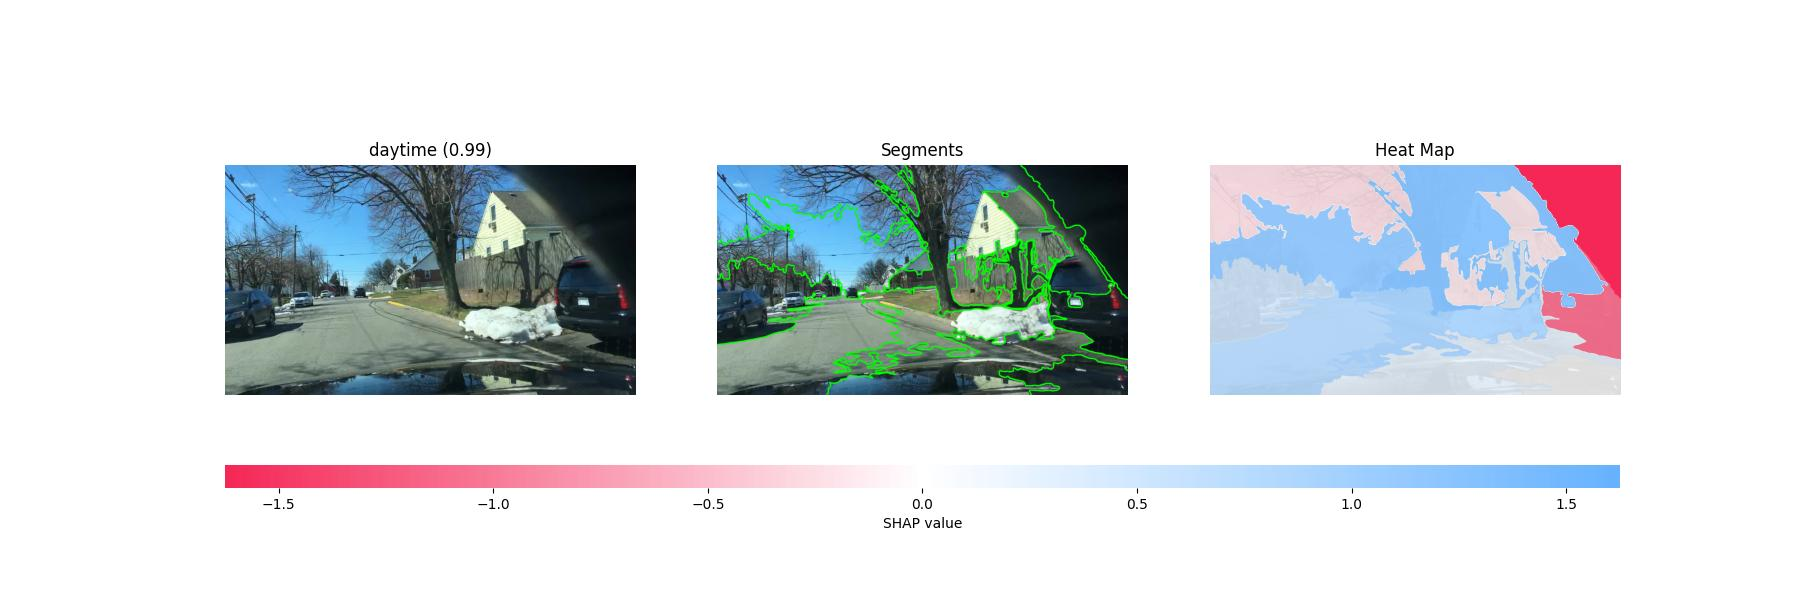

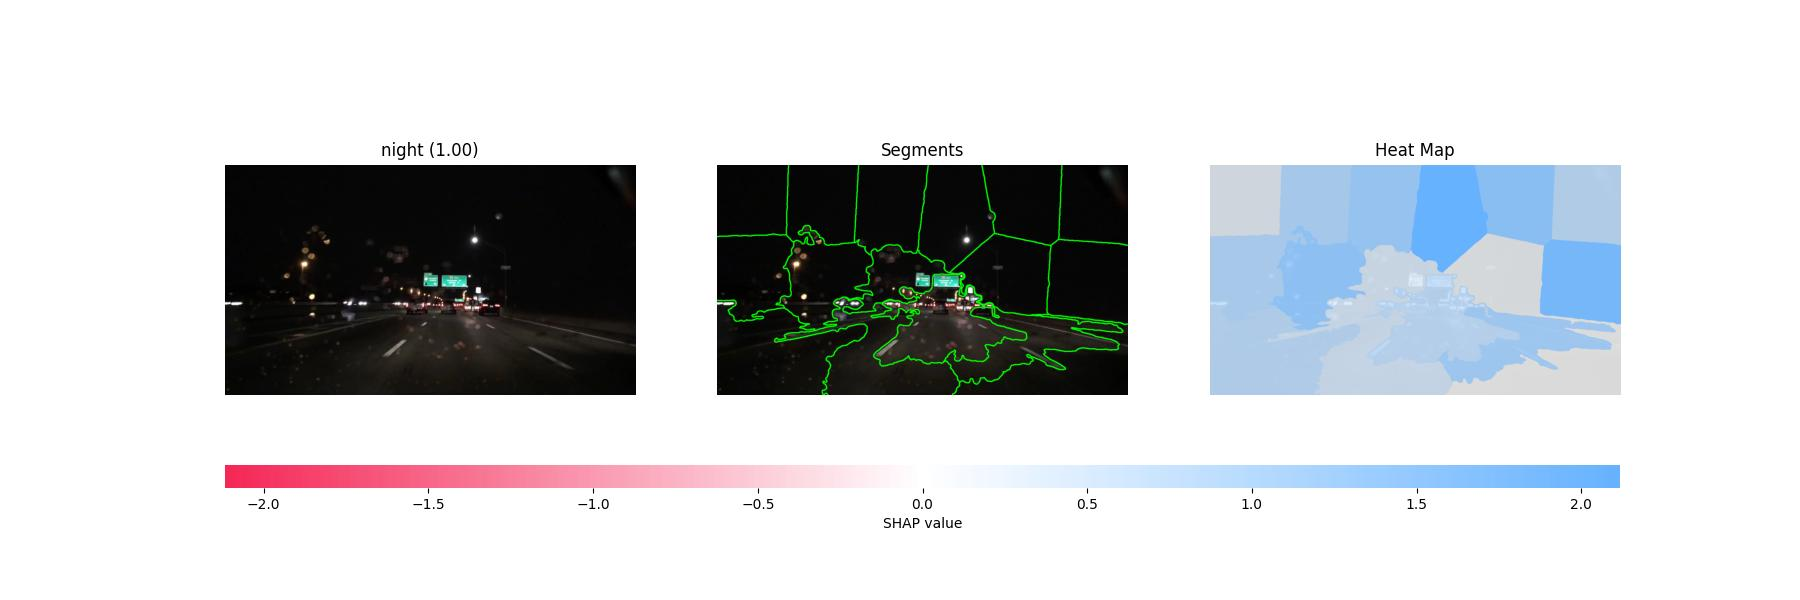

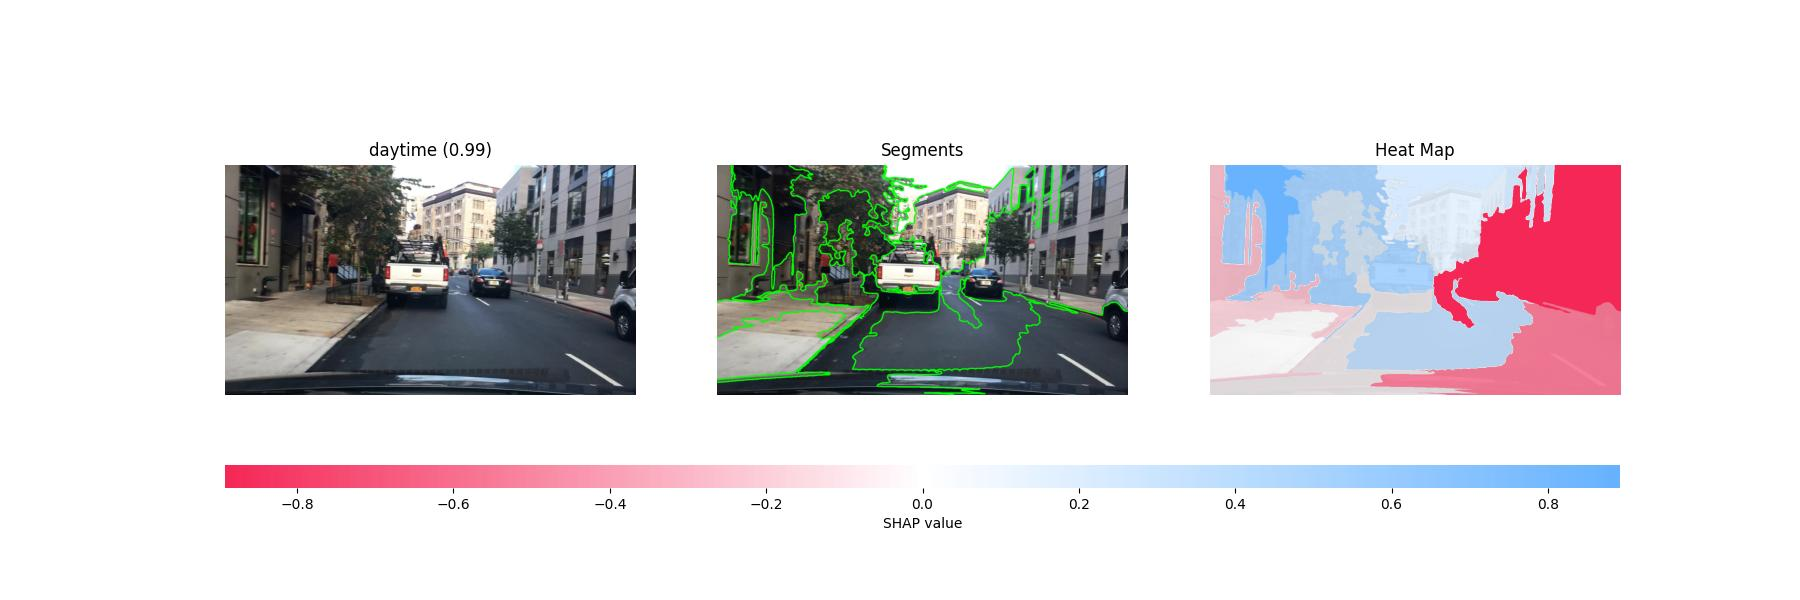

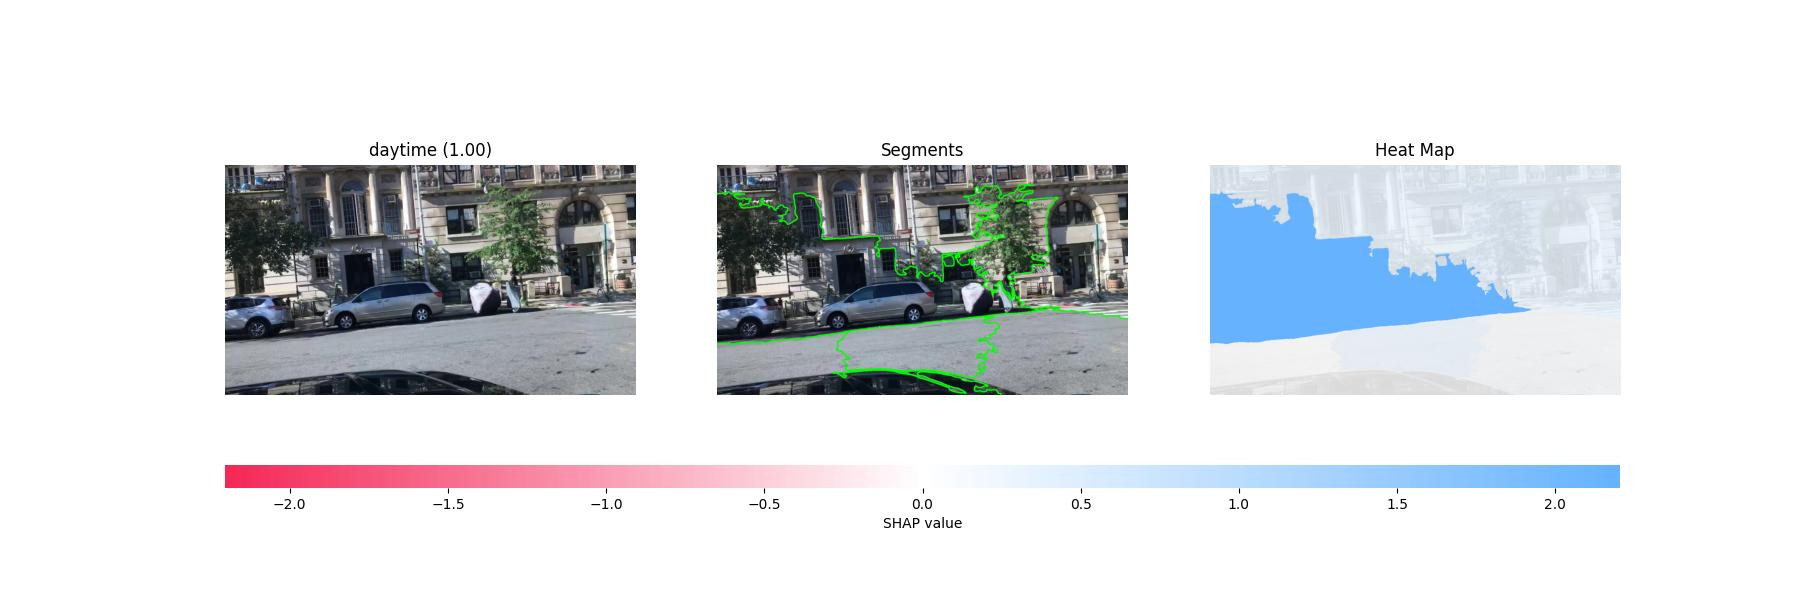

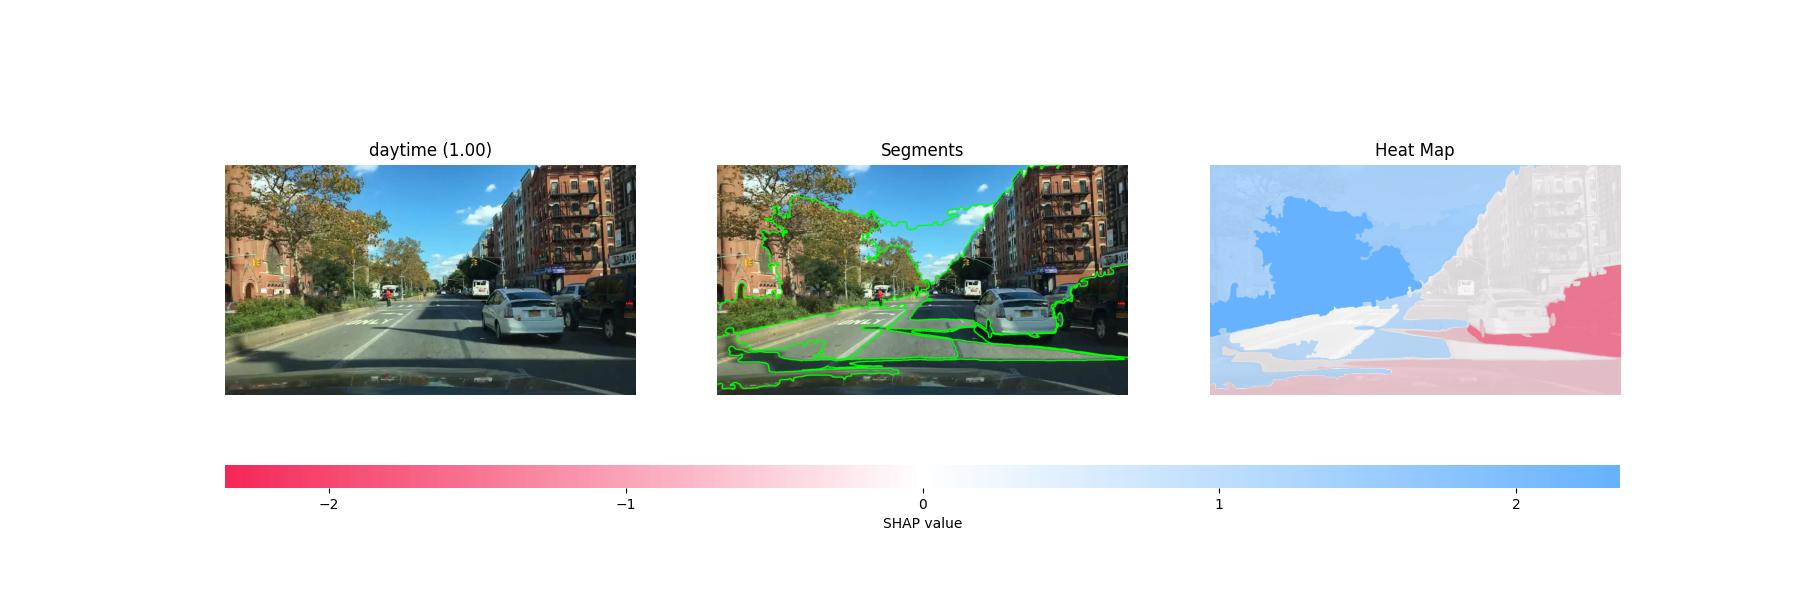

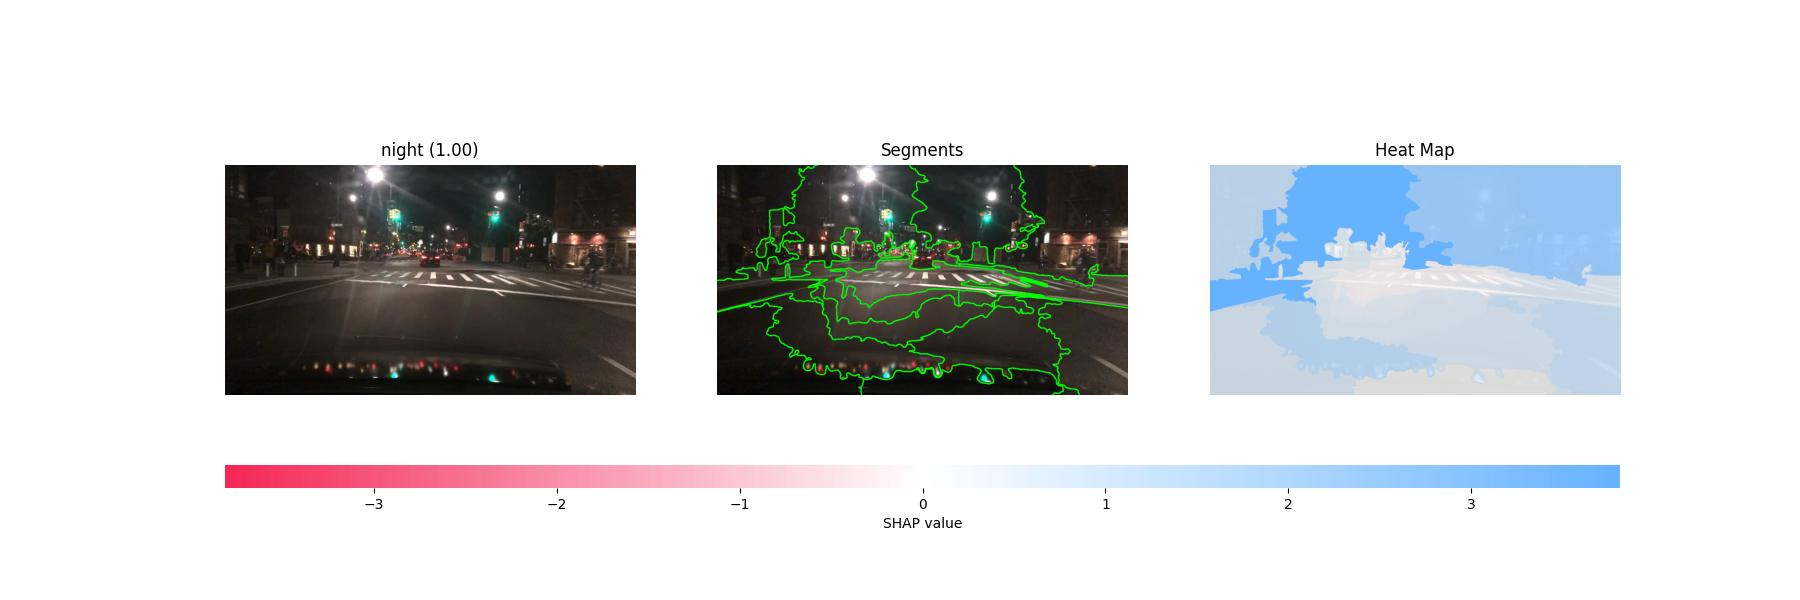

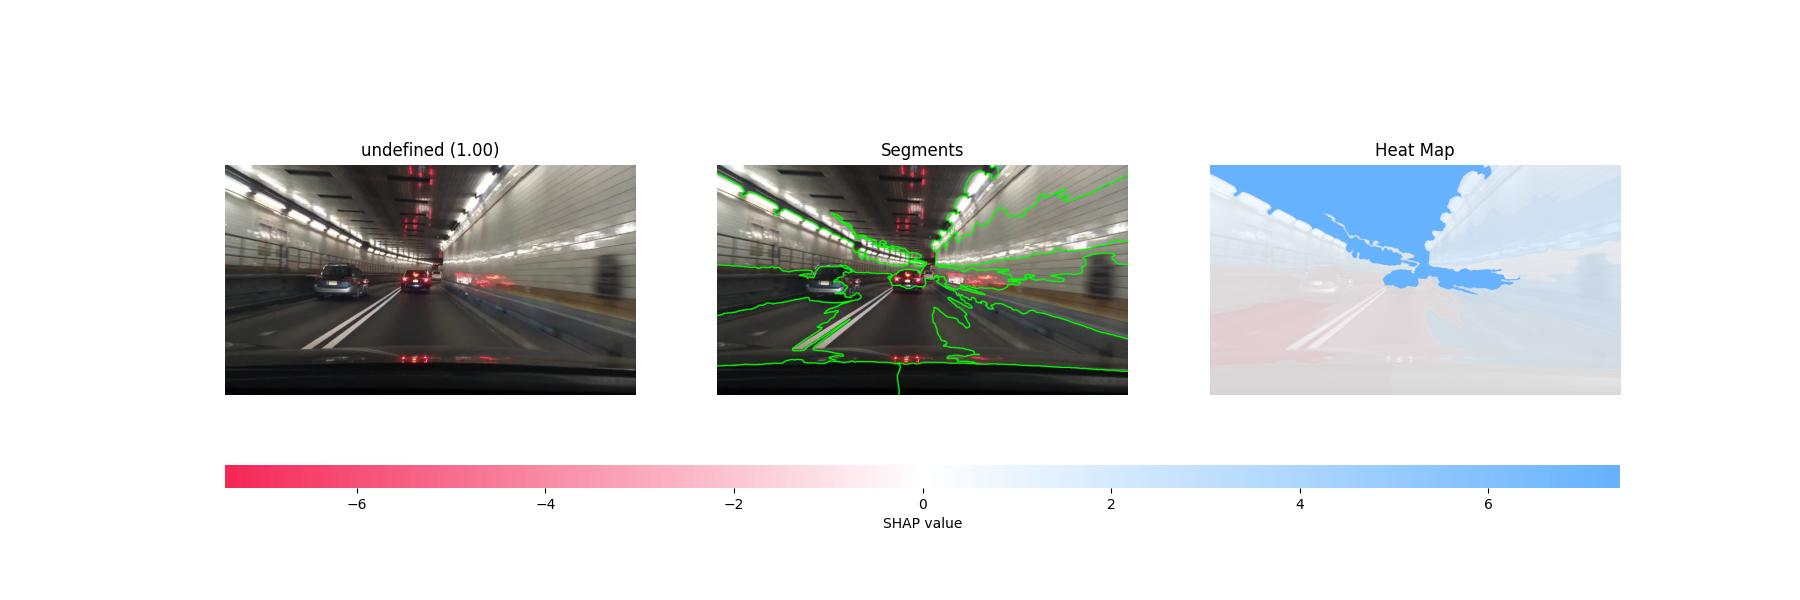

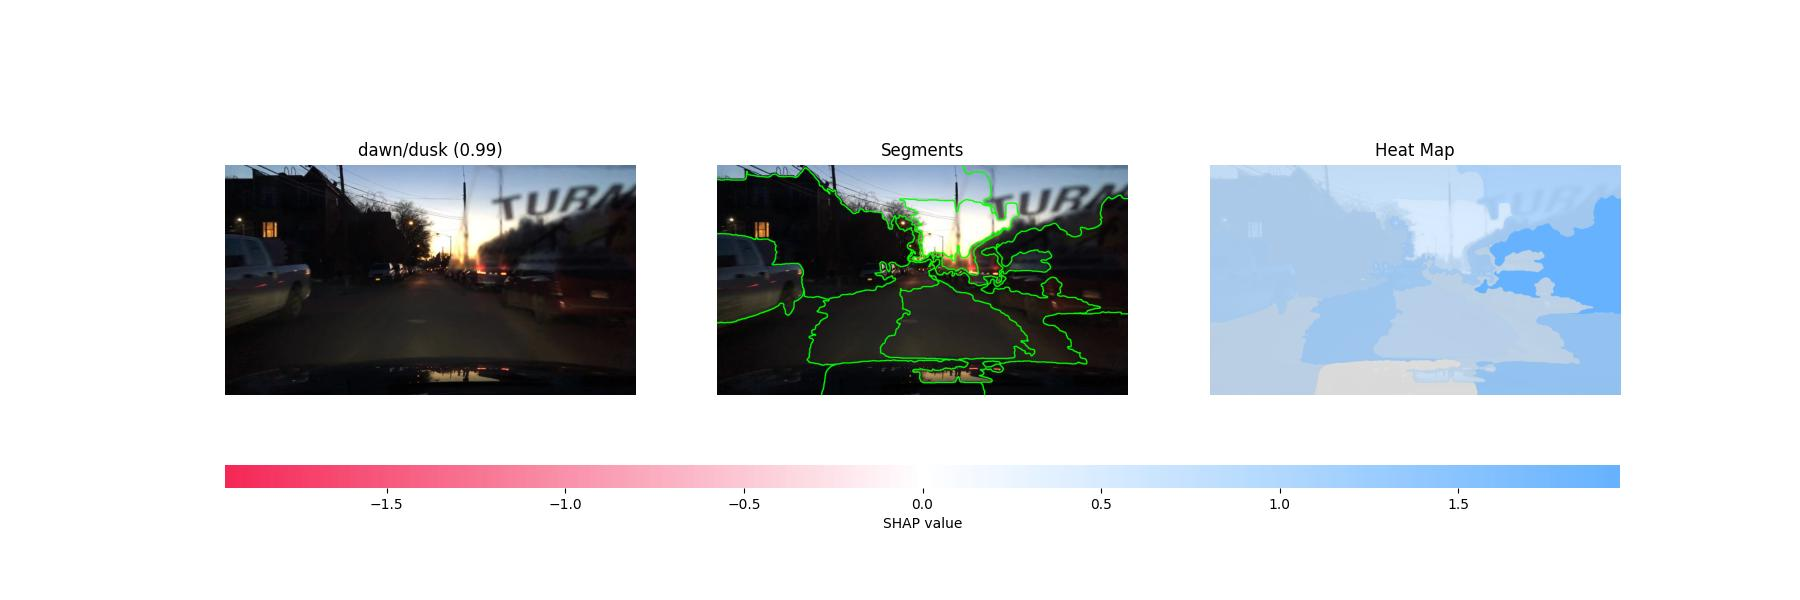

In [4]:
s3_client = boto3.client('s3')
output_objects = s3_client.list_objects(Bucket=bucket, Prefix=clarify_output_prefix)

result_images = []
for file_obj in output_objects["Contents"]:
    file_name = os.path.basename(file_obj["Key"])
    if os.path.splitext(file_name)[1] == ".jpeg":
        result_images.append(file_name)

    print(f"Downloading s3://{bucket}/{file_obj['Key']} ...")
    s3_client.download_file(bucket, file_obj["Key"], file_name)

for img in result_images:
    display(Image(img))